## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

In [3]:
path = Path('/home/apancham91/images/unique_images')
#path.mkdir(exist_ok=True)
path

PosixPath('/home/apancham91/images/unique_images')

In [4]:
import os
len(os.listdir(path))

5858

In [5]:
import pathlib
sorted(pathlib.Path('/home/apancham91/images/unique_images').glob('*.csv'))

[PosixPath('/home/apancham91/images/unique_images/test_predictions_pwc2.csv'),
 PosixPath('/home/apancham91/images/unique_images/unique_label.csv')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [6]:
df = pd.read_csv(path/'unique_label.csv')
df.head()

,image_name,tags
0,2FRescUAV_17917_Pt.Blanche_modified_1_masked,partial
1,2FRescUAV_17917_Pt.Blanche_modified_2_masked,destroyed
2,2FRescUAV_17917_Pt.Blanche_modified_3_masked,significant
3,2FRescUAV_17917_Pt.Blanche_modified_4_masked,none
4,2FRescUAV_17917_Pt.Blanche_modified_5_masked,none


In [7]:
df[df.image_name.str.lower().str.contains('cayhill')]

,image_name,tags


In [8]:
df.tags.value_counts()

none           2790
partial        1070
significant     800
destroyed       439
Name: tags, dtype: int64

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., max_rotate=30)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [10]:
np.random.seed(42)
src = (ImageDataBunch.from_csv(path, csv_labels='unique_label.csv', folder='', suffix='.jpg')
        .random_split_by_pct(0.2)
        .label_from_df(sep=' '))

In [11]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

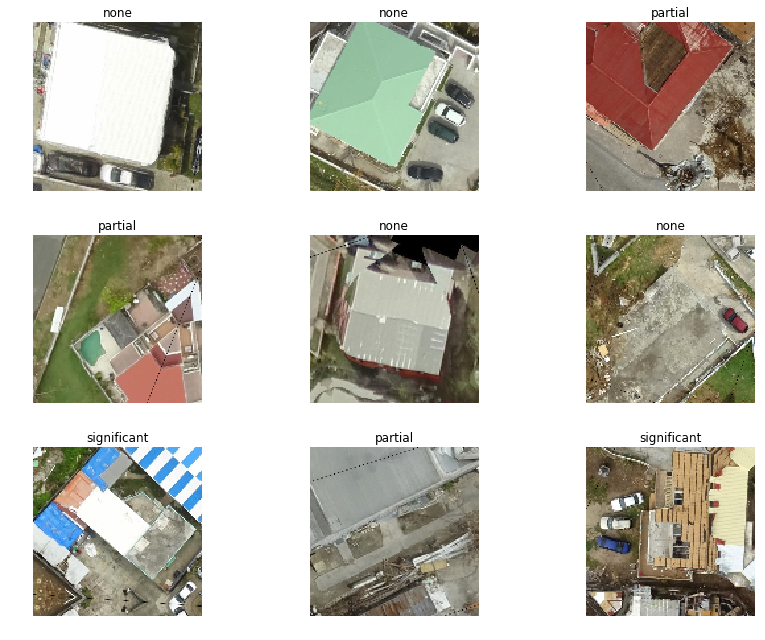

In [12]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [13]:
arch = models.resnet50

In [14]:
acc_02 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2, beta=1.0)
learn = create_cnn(data, arch, metrics=[accuracy_thresh, f_score])

We use the LR Finder to pick a good learning rate.

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


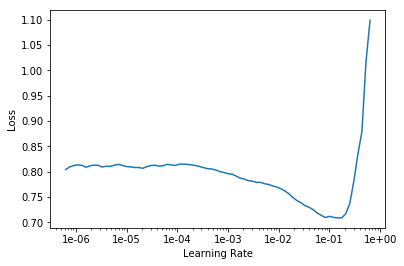

In [16]:
learn.recorder.plot()

Then we can fit the head of our network.

In [17]:
lr = 0.03

In [18]:
learn.fit_one_cycle(5, slice(lr))

Total time: 00:45
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.523913    0.423495    0.809130         0.615564  (00:10)
2      0.465675    0.436136    0.800858         0.608456  (00:08)
3      0.436560    0.390962    0.827512         0.611724  (00:08)
4      0.400302    0.375375    0.833640         0.665645  (00:08)
5      0.378996    0.372112    0.831495         0.650735  (00:08)



In [19]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


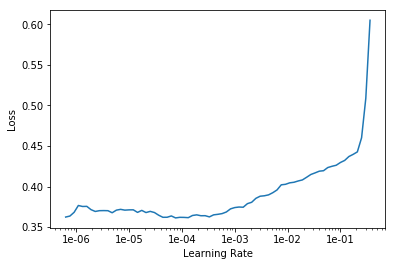

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 00:51
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.363382    0.372940    0.832414         0.643995  (00:10)
2      0.363459    0.373076    0.832414         0.646650  (00:10)
3      0.360488    0.373015    0.830882         0.647345  (00:10)
4      0.357405    0.372464    0.831495         0.649510  (00:09)
5      0.353198    0.372918    0.831189         0.652574  (00:10)



In [23]:
learn.save('stage-2-rn50')

In [24]:
data = (src.transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [25]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


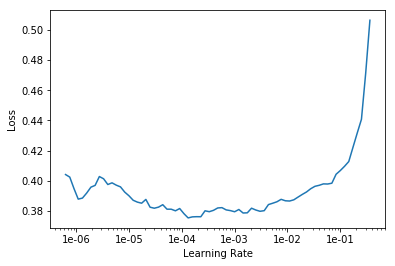

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr=5*1e-4

In [28]:
learn.fit_one_cycle(5, slice(lr))

Total time: 01:42
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.380321    0.384359    0.832108         0.634886  (00:21)
2      0.377994    0.378213    0.834252         0.642443  (00:20)
3      0.365750    0.374719    0.833027         0.634886  (00:20)
4      0.366455    0.375448    0.832108         0.641136  (00:20)
5      0.366266    0.375202    0.834252         0.644077  (00:20)



In [29]:
learn.save('stage-1-256-rn50')

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(5, slice(1e-6, 2*1e-3))

Total time: 02:11
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.368341    0.377706    0.839461         0.652369  (00:26)
2      0.369116    0.382405    0.833640         0.642157  (00:26)
3      0.360428    0.370527    0.841605         0.656413  (00:25)
4      0.341129    0.373845    0.843137         0.665033  (00:26)
5      0.333872    0.373552    0.844056         0.668505  (00:25)



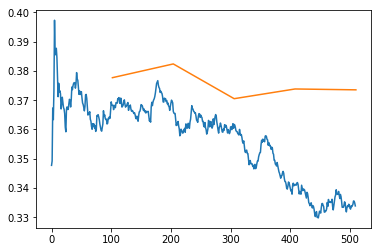

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.save('stage-2-256-rn50')

In [34]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [35]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [36]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (3264 items)
[MultiCategory partial, MultiCategory destroyed, MultiCategory none, MultiCategory none, MultiCategory significant]...
Path: .
x: ImageItemList (3264 items)
[Image (3, 1421, 1786), Image (3, 1912, 1176), Image (3, 1126, 1221), Image (3, 1555, 1327), Image (3, 438, 378)]...
Path: /home/apancham91/images/unique_images;
Valid: LabelList
y: MultiCategoryList (816 items)
[MultiCategory none, MultiCategory none, MultiCategory significant, MultiCategory none, MultiCategory none]...
Path: .
x: ImageItemList (816 items)
[Image (3, 541, 631), Image (3, 346, 355), Image (3, 748, 843), Image (3, 597, 661), Image (3, 387, 308)]...
Path: /home/apancham91/images/unique_images;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  

In [37]:
learn.data = (src.add_test_folder('cayhill')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [38]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1152: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [39]:
len(predictions[0])

625

In [40]:
def find_tags(pred, thresh):
    classes = ""
    max_val = 0
    max_idx = 0
    for idx, val in enumerate(pred):
        if val > max_val:
            max_val = val
            max_idx = idx
    classes = f'{classes} {learn.data.classes[max_idx]}'
    return classes.strip()

In [41]:
def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.5)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

In [42]:
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.5)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [43]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0


In [44]:
df.tags.value_counts()

none           445
partial         92
significant     69
destroyed       19
Name: tags, dtype: int64

significant


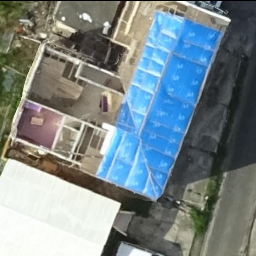

In [45]:
predict(3)

In [46]:
from sklearn.metrics import f1_score, accuracy_score


In [50]:
df_cayhill = pd.read_csv('/home/apancham91/images/unique_images/cayhill/cayhill_label.csv')

In [51]:
df_compare = df_cayhill.merge(df.rename(columns={'tags':'preds'}),how='left', on='image_name', validate="1:1")

In [52]:
df_compare.head()

,image_name,tags,preds
0,2FRescUAV_28917_CayHill_modified_1_masked,none,none
1,2FRescUAV_28917_CayHill_modified_2_masked,destroyed,significant
2,2FRescUAV_28917_CayHill_modified_3_masked,destroyed,significant
3,2FRescUAV_28917_CayHill_modified_4_masked,none,none
4,2FRescUAV_28917_CayHill_modified_5_masked,none,none


In [53]:
y_pred = df_compare.preds.values
y_true = df_compare.tags.values

In [54]:
f1_score(y_true, y_pred, average='weighted') 

0.6423309580252813

In [55]:
accuracy_score(y_true, y_pred) 

0.6736

In [56]:
learn.data = (src.add_test_folder('test_images')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [57]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1152: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [58]:
len(predictions[0])

919

In [59]:
df_final = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df_final.loc[idx] = [image_name, tags]

Completed: 0


In [60]:
df_final.head()

,image_name,tags
0,2FRescUAV_17917_Middle_modified_858_masked,destroyed
1,2FRescUAV_17917_Middle_modified_112_masked,none
2,2FRescUAV_17917_Middle_modified_11_masked,significant
3,2FRescUAV_17917_Middle_modified_691_masked,none
4,2FRescUAV_17917_Middle_modified_843_masked,none


In [61]:
df_final.to_csv('test_predictions_pwc2.csv',index=False)

In [62]:
!pwd

/home/apancham91/notebooks/tutorials/fastai/course-v3/nbs/dl1


In [63]:
df_final.to_csv('/home/apancham91/images/unique_images/test_predictions_pwc2.csv',index=False)